### Examine the Data

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# define the plot size default
from pylab import rcParams
rcParams['figure.figsize'] = (12,5)

# load specific forecasting tools
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import mse,rmse

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")


# Read the dataset
df = pd.read_csv('waterTank_ctrl_stuckAt0.csv', index_col=0, header=0, parse_dates=True)
df.index.freq = 'MS'

df.head()


,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
Time,,,,,,,
0.00,1.000000e-06,0.000000e+00,0,0.0,0,0.0,0.0
0.05,6.890000e-07,3.110000e-07,0,0.0,0,0.0,0.0
0.10,3.333928e-03,4.050000e-07,1,0.0,0,0.0,0.0
0.15,5.448433e-02,8.850002e-03,1,0.0,0,0.0,0.0
0.20,7.717051e-02,2.949715e-02,0,0.0,0,0.0,0.0


In [36]:
df.isna().sum()

Tank1WaterLevel    0
Tank2WaterLevel    0
Tank1InFlow        0
Tank2OutFlow       0
wt3_valve          0
Tank3OutFlow       0
Tank2.level        0
dtype: int64

In [37]:
len(df)

15001

### Plot the source data

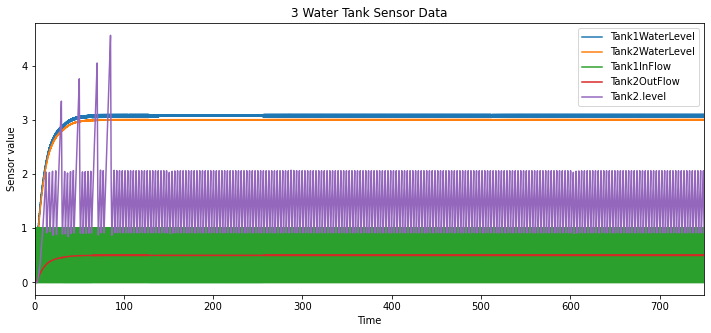

In [38]:
# ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
title = '3 Water Tank Sensor Data'
ylabel = 'Sensor value'
xlabel = ''
ax = df['Tank1WaterLevel'].plot(legend=True, title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
df['Tank2WaterLevel'].plot(legend=True)
df['Tank1InFlow'].plot(legend=True)
df['Tank2OutFlow'].plot(legend=True)
# df['wt3_valve'].plot(legend=True)
# df['Tank3OutFlow'].plot(legend=True)
df['Tank2.level'].plot(legend=True)
plt.show()

In [39]:
# Augmented Dickey-Fuller Test
def adf_test(series, title=''):
    '''
    Hypothesis Test for Stationarity
    Pass in a time series and an optional title, return an ADF report
    '''
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC')
    labels = ['ADF test statistics','p-value','#lags','#observations'] # use help(adfuller) to understand why these labels are chosen
    
    outcome = pd.Series(result[0:4],index=labels)
    
    for key,val in result[4].items():
        outcome[f'critical value ({key})'] = val
        
    print(outcome.to_string()) # this will not print the line 'dtype:float64'
    
    if result[1] <= 0.05:
        print('Strong evidence against the null hypothesis') # Ho is Data is not stationary, check help(adfuller)
        print('Reject the null hypothesis')
        print('Data is Stationary')
    else:
        print('Weak evidence against the Null hypothesis')
        print('Fail to reject the null hypothesis')
        print('Data has a unit root and is non stationary')

In [40]:
adf_test(df['Tank1WaterLevel'])

Augmented Dickey-Fuller Test: 
ADF test statistics    -1.325979e+01
p-value                 8.443583e-25
#lags                   4.200000e+01
#observations           1.495800e+04
critical value (1%)    -3.430787e+00
critical value (5%)    -2.861733e+00
critical value (10%)   -2.566873e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data is Stationary


Take the first order difference of the entire dataframe and re-run the dickey fuller test

In [41]:
# All the correlated features are stationary.
df.head()

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
Time,,,,,,,
0.00,1.000000e-06,0.000000e+00,0,0.0,0,0.0,0.0
0.05,6.890000e-07,3.110000e-07,0,0.0,0,0.0,0.0
0.10,3.333928e-03,4.050000e-07,1,0.0,0,0.0,0.0
0.15,5.448433e-02,8.850002e-03,1,0.0,0,0.0,0.0
0.20,7.717051e-02,2.949715e-02,0,0.0,0,0.0,0.0


In [42]:
len(df)

15001

In [43]:
# Train Test Split
nobs = 3000
train = df.iloc[:-nobs]
test = df.iloc[-nobs:]
len(train), len(test)

(12001, 3000)

### VAR Model Order Selection

In [44]:
p = [1,2,3,4,5,6,7] # try with list of 7 p values
p = list(range(1,20))
aic, bic = [], []
for i in p:
    model = VAR(train)
    results = model.fit(i)
    aic.append(results.aic)
    bic.append(results.bic)
    print(f'VAR Order {i}')
    print('AIC: {}'.format(results.aic))
    print('BIC: {}'.format(results.bic))
    print()

min_aic = min(aic)
min_aic_index = aic.index(min_aic) + 1
min_bic = min(bic)
min_bic_index = bic.index(min_bic) + 1
print('Order {0} has the least AIC value. Let us select p = {0} in the modelling'.format(min_aic_index))


VAR Order 1
AIC: -60.25599065458151
BIC: -60.22149156558058

VAR Order 2
AIC: -65.44869341213253
BIC: -65.38400295858172

VAR Order 3
AIC: -68.63391300026282
BIC: -68.53902683021575

VAR Order 4
AIC: -71.52332313956657
BIC: -71.39823690007373

VAR Order 5
AIC: -72.98170737411009
BIC: -72.82641671121854

VAR Order 6
AIC: -74.05465440249512
BIC: -73.86915496124814

VAR Order 7
AIC: -75.04611308530082
BIC: -74.83040050973761

VAR Order 8
AIC: -75.36459420699552
BIC: -75.1186641401509

VAR Order 9
AIC: -75.83572794680178
BIC: -75.55957603070584

VAR Order 10
AIC: -77.4682609521296
BIC: -77.16188282780739

VAR Order 11
AIC: -77.83137982766655
BIC: -77.4947711351378

VAR Order 12
AIC: -78.5988158018882
BIC: -78.23197218016695

VAR Order 13
AIC: -78.84467108752617
BIC: -78.4475881746205

VAR Order 14
AIC: -79.39404139819295
BIC: -78.96671483110465

VAR Order 15
AIC: -79.61940826420143
BIC: -79.16183367892565

VAR Order 16
AIC: -80.06617008288008
BIC: -79.57834311440506

VAR Order 17
AIC: -80.

In [45]:
# let's confirm that both the variables are included in the model
model.endog_names

['Tank1WaterLevel',
 'Tank2WaterLevel',
 'Tank1InFlow',
 'Tank2OutFlow',
 'wt3_valve',
 'Tank3OutFlow',
 'Tank2.level']

In [46]:
from IPython.display import Markdown as md
md("Fit the VAR( {{}} ) model".format(min_aic_index))

Fit the VAR( {} ) model

### Fit the VAR {{min_aic_index}}  model

In [47]:
min_aic_index

19

In [48]:
results = model.fit(min_aic_index)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 09, May, 2023
Time:                     16:23:00
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -80.9725
Nobs:                     11982.0    HQIC:                  -81.3570
Log likelihood:           370499.    FPE:                3.82662e-36
AIC:                     -81.5511    Det(Omega_mle):     3.54002e-36
--------------------------------------------------------------------
Results for equation Tank1WaterLevel
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                       0.017958         0.002187            8.213           0.000
L1.Tank1WaterLevel          0.331679         0.010402           31.888           0.000
L1.Tank2WaterLevel        

### Predict the next 20 values

In [49]:
# For predictions, VAR model uses .forecast() instead of predictions.
lag_order = results.k_ar
lag_order

19

In [50]:
df.head()

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
Time,,,,,,,
0.00,1.000000e-06,0.000000e+00,0,0.0,0,0.0,0.0
0.05,6.890000e-07,3.110000e-07,0,0.0,0,0.0,0.0
0.10,3.333928e-03,4.050000e-07,1,0.0,0,0.0,0.0
0.15,5.448433e-02,8.850002e-03,1,0.0,0,0.0,0.0
0.20,7.717051e-02,2.949715e-02,0,0.0,0,0.0,0.0


In [51]:
steps = 20
# z = results.forecast(y=train.values[-lag_order:], steps = 20)
z = results.forecast(y=train.values[-lag_order:], steps=steps)
z

array([[ 3.09253893e+00,  3.00415296e+00, -2.17117559e-03,
         5.00300924e-01,  3.67944687e-02,  9.54921389e-03,
         1.88144872e+00],
       [ 3.06259199e+00,  3.00403177e+00, -9.82728272e-04,
         5.00992960e-01,  8.07526101e-02,  1.12198539e-01,
         1.90490852e+00],
       [ 3.04797061e+00,  2.99866597e+00,  7.95923034e-03,
         5.00277028e-01,  1.14179609e-01,  2.31091821e-01,
         1.91585154e+00],
       [ 3.07881242e+00,  2.99454670e+00,  1.00049070e+00,
         4.98966576e-01,  1.55470790e-01,  3.11115109e-01,
         1.92771661e+00],
       [ 3.09517247e+00,  2.99832252e+00,  9.96636045e-01,
         4.99268286e-01,  1.91748022e-01,  4.15368301e-01,
         1.93031045e+00],
       [ 3.08099213e+00,  3.00562541e+00,  1.26837715e-05,
         5.00787604e-01,  2.26563970e-01,  4.92944039e-01,
         1.93158854e+00],
       [ 3.06245101e+00,  3.00399597e+00, -8.48863634e-04,
         5.00985761e-01,  2.59368059e-01,  5.67188706e-01,
         1.9272607

In [52]:
test

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
Time,,,,,,,
600.05,3.092560,3.004144,0,0.500300,0,0.000000,1.881051
600.10,3.062618,3.004037,0,0.500995,0,0.000000,1.911066
600.15,3.047931,2.998697,0,0.500285,0,0.000000,1.931103
600.20,3.078778,2.994546,1,0.498971,0,0.000000,1.961123
600.25,3.095067,2.998294,1,0.499269,0,0.000000,1.981086
...,...,...,...,...,...,...,...
749.80,3.092561,3.004145,0,0.500300,1,1.452444,1.036403
749.85,3.071222,3.005454,0,0.501029,1,1.400533,0.999361
749.90,3.047931,2.998697,0,0.500285,1,1.327987,0.947595


In [53]:
# idx = pd.date_range(start='1/1/2015', periods=12, freq='MS')
# df_forecast = pd.DataFrame(z, index=idx, columns=['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level'])
df_forecast = pd.DataFrame(z, columns=['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level'])
df_forecast[:5]

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
0,3.092539,3.004153,-0.002171,0.500301,0.036794,0.009549,1.881449
1,3.062592,3.004032,-0.000983,0.500993,0.080753,0.112199,1.904909
2,3.047971,2.998666,0.007959,0.500277,0.114180,0.231092,1.915852
3,3.078812,2.994547,1.000491,0.498967,0.155471,0.311115,1.927717
4,3.095172,2.998323,0.996636,0.499268,0.191748,0.415368,1.930310


### Plot the results

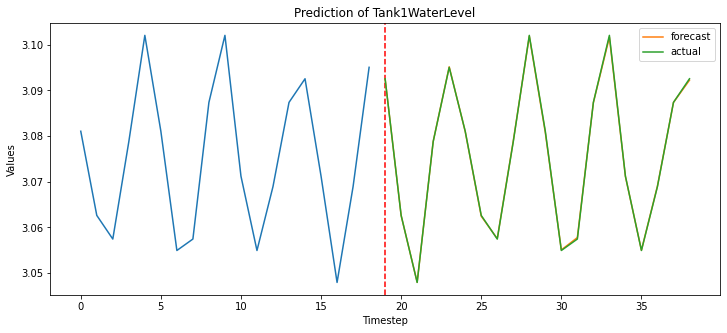

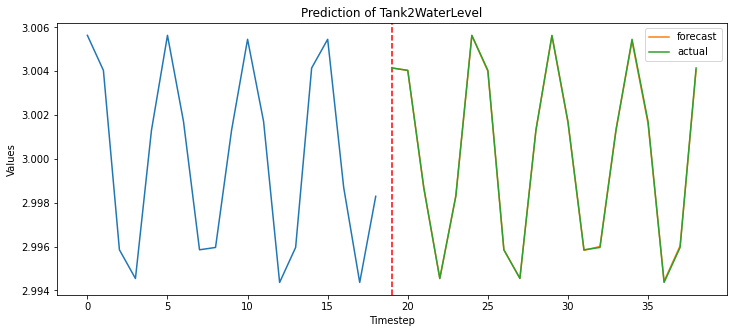

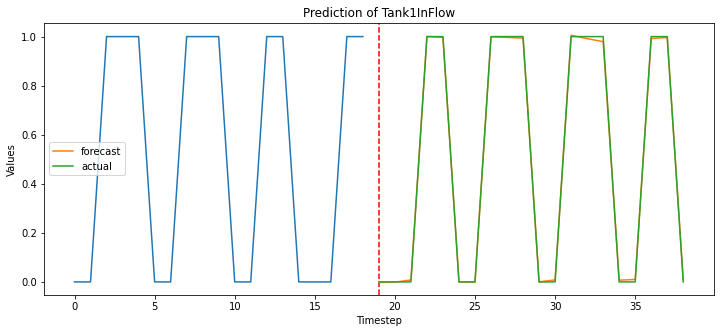

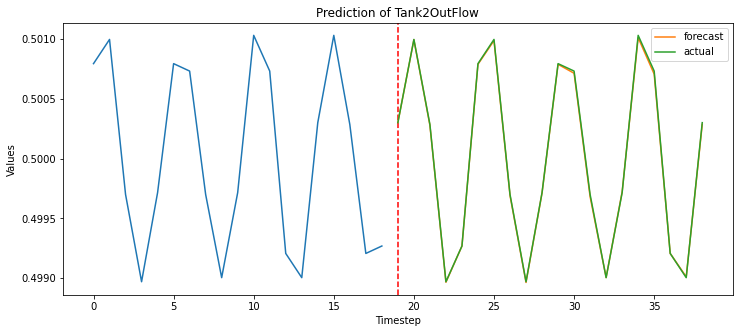

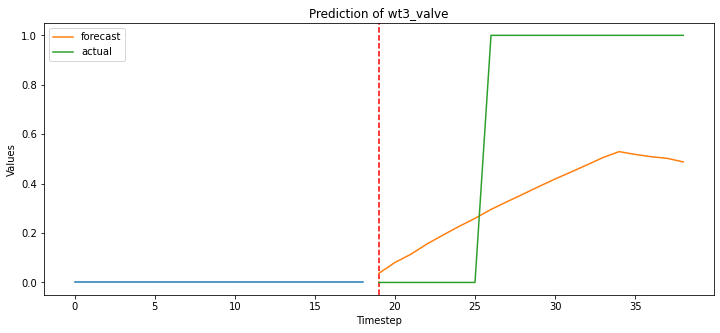

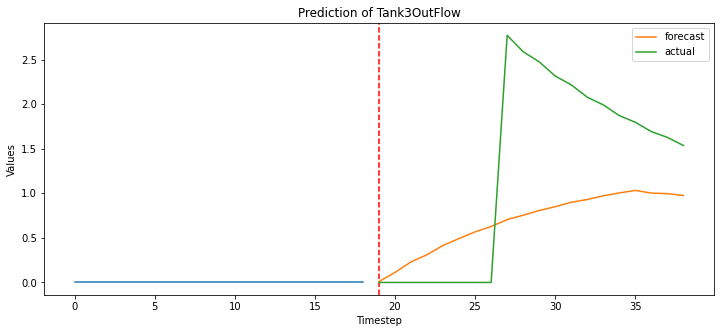

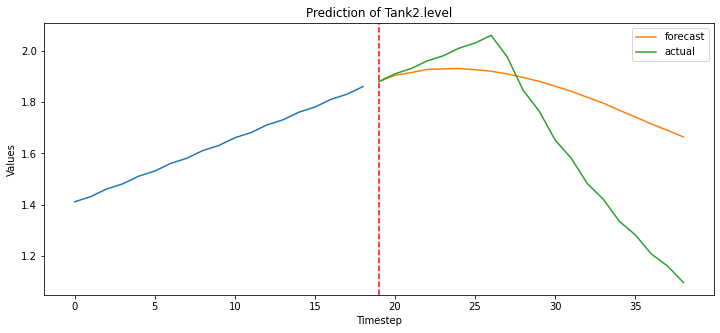

In [54]:
attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
for i in range(len(attr)):
    title = "Prediction of {}".format(attr[i])
    actual_index = pd.Index(list(range(lag_order)))
    actual = train.iloc[-lag_order:,:]
    
    index = pd.Index(list(range(lag_order, lag_order + steps)))
    actual = actual.set_index(actual_index)
    pred = df_forecast.set_index(index)
    actual_test = test.iloc[:lag_order+1,:].set_index(index)
    # draw a vertical line at x=19
    plt.axvline(x=lag_order, ls='--', color='red')
#     pred = df_forecast
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel("Values")
    plt.plot(actual.iloc[:,i])
    plt.plot(pred.iloc[:,i], label="forecast")
    plt.plot(actual_test.iloc[:,i], label="actual")
    plt.legend()
    plt.show()

### Model Evaluation

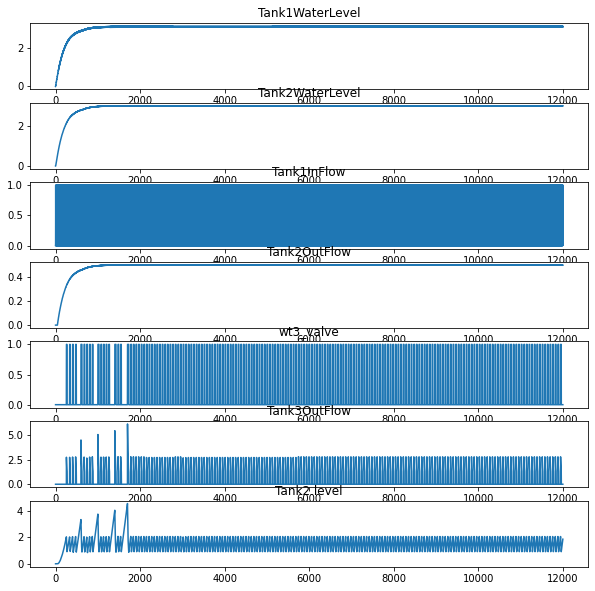

In [55]:
results.plot();

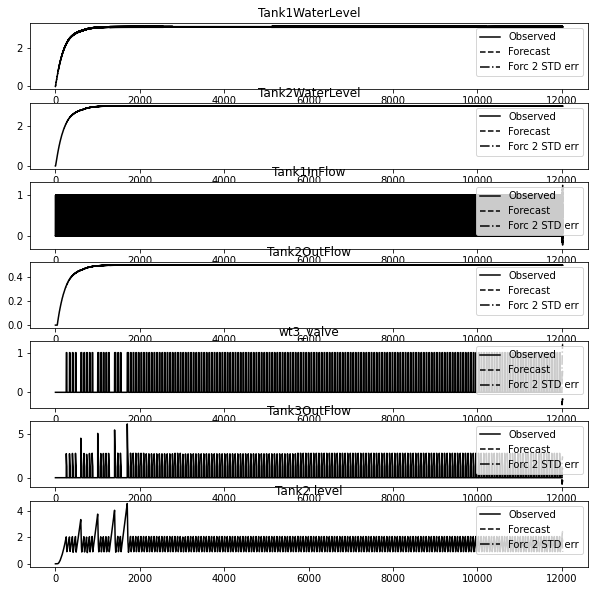

In [56]:
results.plot_forecast(20);

In [57]:
len(df_forecast)

20

In [58]:
len(df['Tank1WaterLevel'].iloc[:steps])

20

### Model Evaluation

In [59]:
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
RMSE = []
for feat in attr:
    RMSE.append(rmse(df[feat].iloc[:steps], df_forecast[feat]))

print(RMSE)

[2.953628861066164, 2.9092494453548774, 0.7353347854796284, 0.5000043160908357, 0.37606859726260505, 0.7540361743787987, 1.8484874746222815]


### Save the model

In [60]:
# Serialize andsave the model
import pickle
import statsmodels.api as sm
with open('var_ctrl_stuckat0.pkl', 'wb') as f:
    pickle.dump(results.params, f)
print("Model saved!")

Model saved!


### Define the faulty data

In [61]:
faulty_data = pd.read_csv('test_fault.csv', index_col=0, header=0, parse_dates=True)
faulty_data.index.freq = 'MS'
num_obs = 3000

# train_faulty = faulty_data.iloc[-num_obs:]
# test_faulty = faulty_data.iloc[:-num_obs]

train_faulty = faulty_data.iloc[:-num_obs]
test_faulty = faulty_data.iloc[-num_obs:]
len(train_faulty), len(test_faulty)

(12001, 3000)

### Load the model and reconstruct VAR

In [62]:
with open('var_ctrl_stuckat0.pkl', 'rb') as f:
    params = pickle.load(f)
    
stuckat0_model = sm.tsa.VAR(train)
stuckat0_model.params = params
stuckat0_model_fit = stuckat0_model.fit(min_aic_index)

stuckat0_model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 09, May, 2023
Time:                     16:23:19
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -80.9725
Nobs:                     11982.0    HQIC:                  -81.3570
Log likelihood:           370499.    FPE:                3.82662e-36
AIC:                     -81.5511    Det(Omega_mle):     3.54002e-36
--------------------------------------------------------------------
Results for equation Tank1WaterLevel
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                       0.017958         0.002187            8.213           0.000
L1.Tank1WaterLevel          0.331679         0.010402           31.888           0.000
L1.Tank2WaterLevel        

### Forecast using faulty data

In [63]:
# Use the loaded model to make predictions or perform other analyses
forecast = stuckat0_model_fit.forecast(y=train_faulty.values[-lag_order:], steps=20)
# forecast = golden_model_fit.forecast(params, start=len(train), end=len(train)+10)
forecast

array([[3.09182175e+00, 3.00386017e+00, 4.71625451e-03, 5.00254866e-01,
        2.38166151e+00, 3.65843283e+00, 2.60768514e+01],
       [3.06164069e+00, 3.00354364e+00, 1.93373309e-02, 5.00907849e-01,
        3.71949680e+00, 7.96148034e+00, 2.57166744e+01],
       [3.04794352e+00, 2.99815502e+00, 3.20381602e-02, 5.00160191e-01,
        4.96399708e+00, 1.18355563e+01, 2.51628878e+01],
       [3.07910221e+00, 2.99412288e+00, 1.01679241e+00, 4.98848015e-01,
        6.15551395e+00, 1.51554567e+01, 2.44289677e+01],
       [3.09379099e+00, 2.99769052e+00, 1.00313475e+00, 4.99132390e-01,
        7.27618242e+00, 1.80964931e+01, 2.35503873e+01],
       [3.07866897e+00, 3.00471071e+00, 2.50418152e-02, 5.00607451e-01,
        8.34038783e+00, 2.05951509e+01, 2.25336948e+01],
       [3.06170578e+00, 3.00281009e+00, 5.44878775e-02, 5.00712510e-01,
        9.34419877e+00, 2.27601433e+01, 2.14128380e+01],
       [3.05796635e+00, 2.99468197e+00, 1.06785420e+00, 4.99380324e-01,
        1.03002819e+01, 2

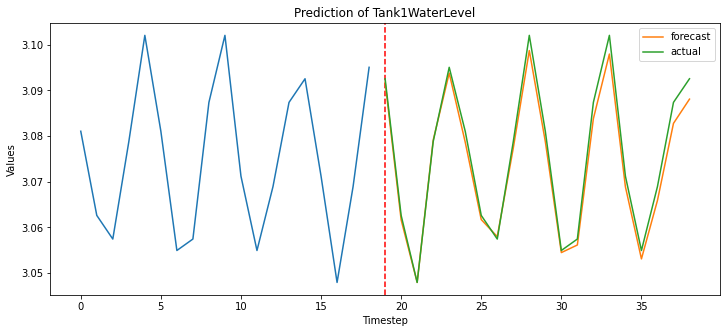

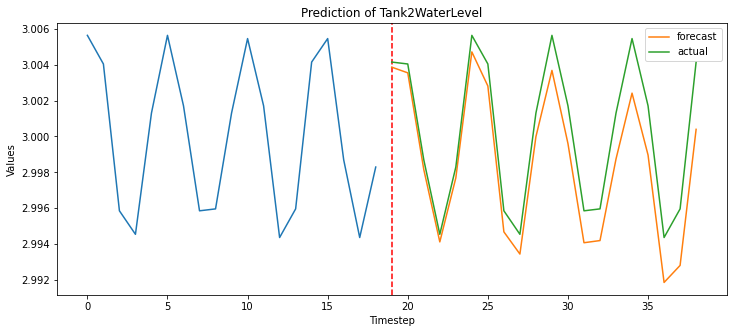

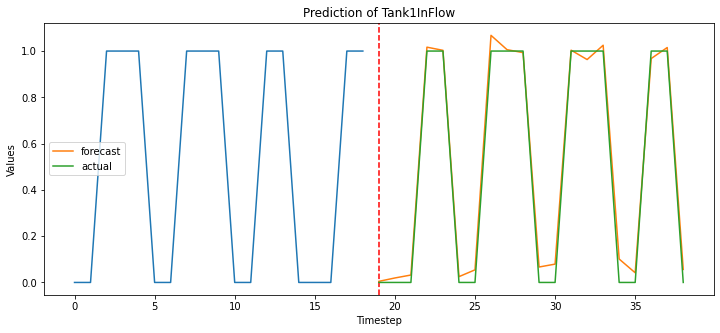

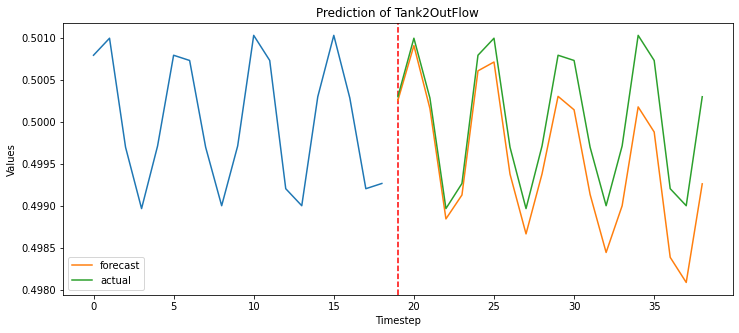

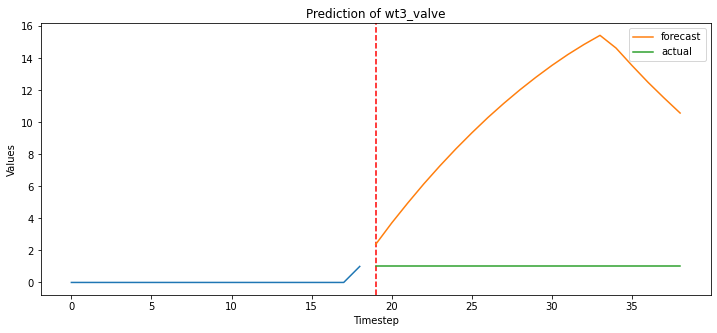

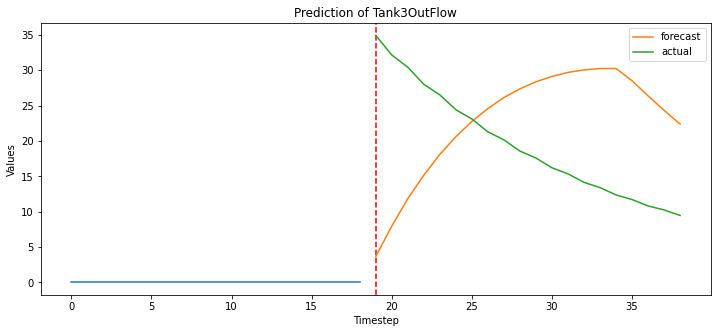

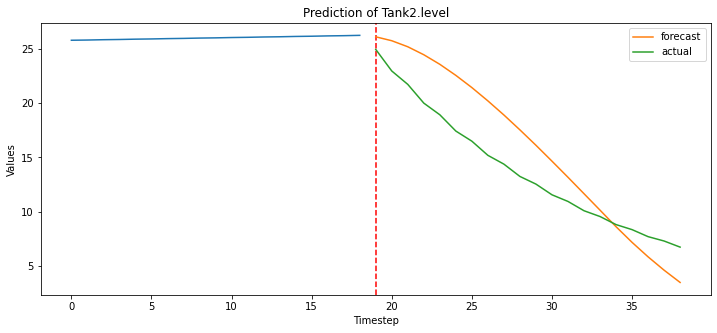

In [64]:
fault_forecast = pd.DataFrame(forecast, columns=['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level'])

attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
for i in range(len(attr)):
    title = "Prediction of {}".format(attr[i])
    actual_index_f = pd.Index(list(range(lag_order)))
    actual_f = train_faulty.iloc[-lag_order:,:]
    
    index_f = pd.Index(list(range(lag_order, lag_order + steps)))
    actual_f = actual_f.set_index(actual_index_f)
    pred_f = fault_forecast.set_index(index_f)
    actual_test_f = test_faulty.iloc[:lag_order+1,:].set_index(index_f)
    # draw a vertical line at x=19
    plt.axvline(x=lag_order, ls='--', color='red')
#     pred = df_forecast
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel("Values")
    plt.plot(actual_f.iloc[:,i])
    plt.plot(pred_f.iloc[:,i], label="forecast")
    plt.plot(actual_test_f.iloc[:,i], label="actual")
    plt.legend()
    plt.show()

In [65]:
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
RMSEf = []
for feat in attr:
    RMSEf.append(rmse(df[feat].iloc[:steps], fault_forecast[feat]))

print(RMSEf)

[2.9517693951701625, 2.9076100727269627, 0.7194923025762103, 0.49954599798099214, 11.128382743658218, 24.0981203348051, 17.67060013929891]


### Increasing the duration of faults

In [66]:
faulty_data_extend = pd.read_csv('test_extend.csv', index_col=0, header=0, parse_dates=True)

faulty_data_extend.index.freq = 'MS'
num_obs = 3000

# train_faulty = faulty_data.iloc[-num_obs:]
# test_faulty = faulty_data.iloc[:-num_obs]

train_faulty_extend = faulty_data_extend.iloc[:-num_obs]
test_faulty_extend = faulty_data_extend.iloc[-num_obs:]
len(train_faulty_extend), len(test_faulty_extend)

(12001, 3000)

In [67]:
# Use the loaded model to make predictions or perform other analyses
forecast_extend = stuckat0_model_fit.forecast(y=train_faulty_extend.values[-lag_order:], steps=20)

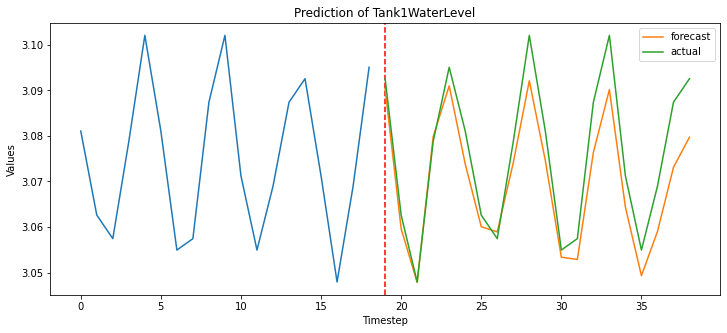

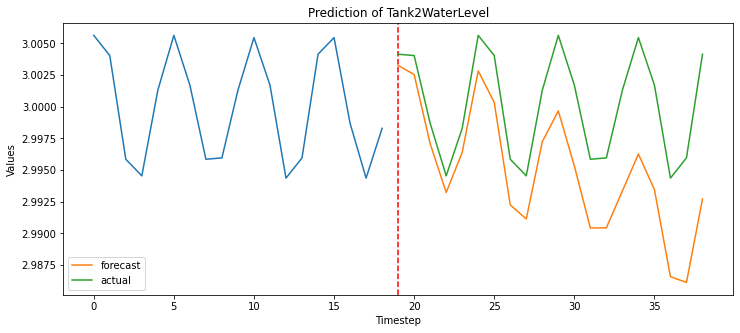

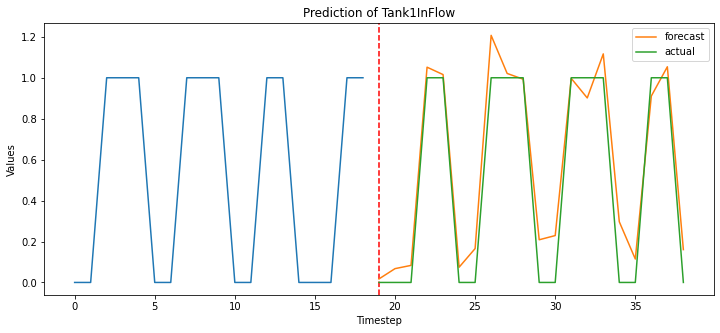

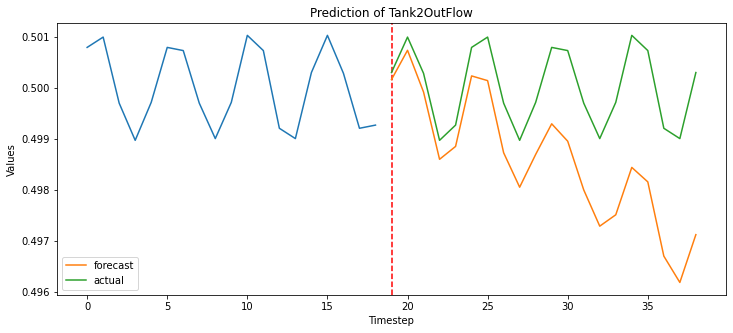

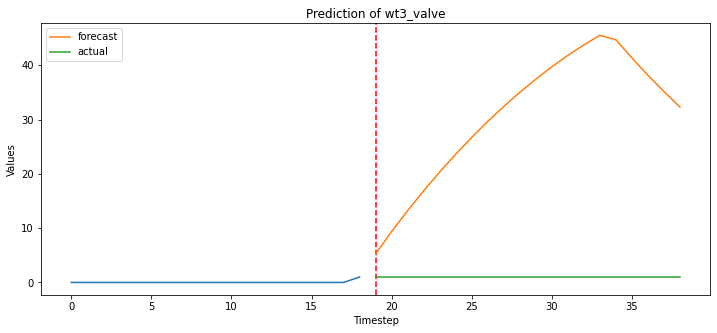

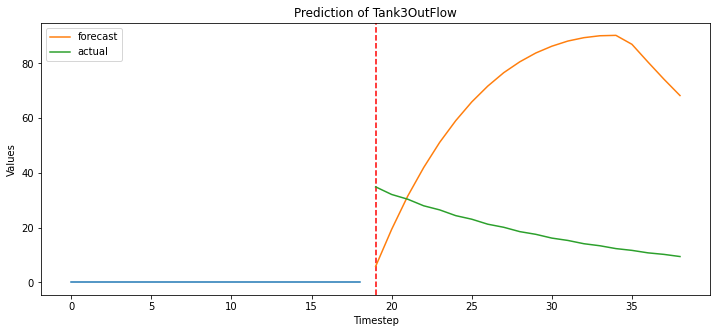

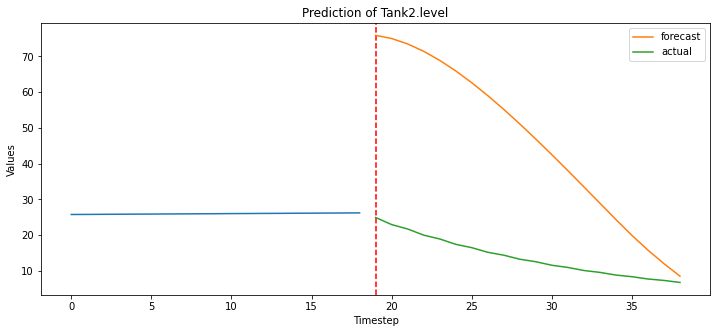

In [68]:
fault_forecast = pd.DataFrame(forecast_extend, columns=['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level'])

attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
for i in range(len(attr)):
    title = "Prediction of {}".format(attr[i])
    actual_index_f = pd.Index(list(range(lag_order)))
    actual_f = train_faulty.iloc[-lag_order:,:]
    
    index_f = pd.Index(list(range(lag_order, lag_order + steps)))
    actual_f = actual_f.set_index(actual_index_f)
    pred_f = fault_forecast.set_index(index_f)
    actual_test_f = test_faulty.iloc[:lag_order+1,:].set_index(index_f)
    # draw a vertical line at x=19
    plt.axvline(x=lag_order, ls='--', color='red')
#     pred = df_forecast
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel("Values")
    plt.plot(actual_f.iloc[:,i])
    plt.plot(pred_f.iloc[:,i], label="forecast")
    plt.plot(actual_test_f.iloc[:,i], label="actual")
    plt.legend()
    plt.show()

In [69]:
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
RMSEf = []
for feat in attr:
    RMSEf.append(rmse(df[feat].iloc[:steps], fault_forecast[feat]))

print(RMSEf)

[2.9479077231134383, 2.904206239232601, 0.6914541099238971, 0.4985894728367055, 32.84283940246593, 71.38222990049606, 51.41923956799442]


In [2]:
print("print")

print
